In [5]:
from __future__ import print_function

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,TimeDistributed
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import layers,models
import h5py
from keras.models import Model
from keras.layers import Layer
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import heapq
import warnings

from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2643237401841409991
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3680104960388383176
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5944326084714759917
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5618860032
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1387142076178331006
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:

class ScaleLayer(Layer):

    def __init__(self,scale, **kwargs):

        self.scale=scale;
        
        super(ScaleLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        super(ScaleLayer, self).build(input_shape)

       
    def call(self, inputs):

        output=tf.image.resize(inputs,[self.scale,self.scale],method=tf.image.ResizeMethod.BICUBIC)


        print(output.shape)

        return output

       

    def compute_output_shape(self, input_shape):
        return (input_shape[0],self.scale,self.scale,3)



def vgg16_head(img_input):

    pooling = 'No'

    include_top = False;



    x = TimeDistributed(ScaleLayer(224))(img_input)

    x = TimeDistributed(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))(x)

    # Block 2
    x = TimeDistributed(layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))(x)

    # Block 3
    x = TimeDistributed(layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2'))(x)
    x = TimeDistributed(layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))(x)

    # Block 4
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))(x)

    # Block 5
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        x = layers.Dense(4096, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        elif pooling =='No':
            x = x;
    return x

In [3]:

class AttentionLayer(Layer):

    def __init__(self, **kwargs):

        
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)


        self.input_shape_r = input_shape;
        print('self.input_shape_r')
        print(self.input_shape_r)

        L_size = 256;

        self.w = self.add_weight(name='w', 
                              shape=[L_size,1],
                              initializer='uniform',
                              trainable=True)
        self.V = self.add_weight(name='V', 
                      shape=[input_shape[2],L_size],
                      initializer='uniform',
                      trainable=True)

        self.U = self.add_weight(name='U', 
                      shape=[input_shape[2],L_size],
                      initializer='uniform',
                      trainable=True)

        

        self.bias_w = self.add_weight(shape=[1,1],
                              initializer='uniform',
                              name='bias_w')
        self.bias_V = self.add_weight(shape=[1,L_size],
                                      initializer='uniform',
                                      name='bias_V')
        self.bias_U = self.add_weight(shape=[1,L_size],
                                      initializer='uniform',
                                      name='bias_U')
        
        self.Save = self.add_weight(name='ForSave', 
              shape=[10,10],
              initializer='uniform',
              trainable=False)
      

  
       
    def call(self, inputs):


        inputs_r = K.expand_dims(inputs,axis=-2)


        print('inputs')
        print(inputs_r.shape)


        dot_products_V = K.dot(inputs_r,self.V)
        dot_products_U = K.dot(inputs_r,self.U)

        dot_products_V += self.bias_V;
        dot_products_U += self.bias_U;


        print('dot product')
        print(dot_products_V.shape)

        tanh_V = K.tanh(dot_products_V);
        sigmoid_U = K.sigmoid(dot_products_U);

        print('tanh')
        print(tanh_V.shape)

        comb_UV = tanh_V*sigmoid_U;

        print('combUV')
        print(comb_UV.shape)

        attention_weights = K.dot(comb_UV,self.w);

        attention_weights +=self.bias_w;

        attention_weights = K.exp(attention_weights);


        print('attention_weights')
        print(attention_weights.shape)


        attention_weights /= K.cast(K.sum(attention_weights,
                                  axis=1,
                                  keepdims=True) + K.epsilon(),
                            K.floatx());
        print('attention_weights sum')
        print(attention_weights.shape)

        #attention_weights = K.expand_dims(attention_weights);
        attention_weights= K.squeeze(attention_weights,axis = -1);
        print('attention_weights last')
        print(attention_weights.shape)

        weighted_output = inputs * attention_weights;

        self.Save =  attention_weights;


        output = K.sum(weighted_output, axis=1)

        print('output')
        print(output.shape)

        return output


       

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[2])
    
    
class FCHeadNet:
  @staticmethod
  def build(baseModel, classes, D):
    # initialize the head model that will be placed on top of
    # the base, then add a FC layer
    headModel = baseModel.output
    headModel = TimeDistributed(layers.Flatten(name='flatten'))(headModel)
    headModel = TimeDistributed(layers.Dense(D, activation='relu', name='fc1'))(headModel)
    headModel = TimeDistributed(layers.Dense(D, activation='relu', name='fc2'))(headModel)
    headModel = AttentionLayer(name='attentionlayer')(headModel)
    headModel = layers.Dense(classes, activation='sigmoid', name='predictions')(headModel)
    # add a softmax layer
    #headModel = layers.Dense(classes, activation="softmax")(headModel)
    #headModel = layers.Dense(classes, activation='softmax', name='predictions2')(headModel)

    # return the model
    return headModel


In [4]:
import random
batch_size = 1
num_classes = 2
epochs = 100

# input image dimensions
img_rows, img_cols = 128, 128

# the data, split between train and test sets

#(x_train, y_train), (x_test, y_test) = mnist.load_data()


p='/home/peppermint/Data_Sci/Attention_ML/2548_many.h5';

db=h5py.File(p);


X_stk, y_stk = db['images'],db['labels'];

X =np.zeros((91,28,128,128,3))
y = np.zeros((91,))

for ij in range(91):
    X[ij,...] = X_stk[ij*28:(ij+1)*28,...]
    y[ij,...] = y_stk[(ij*28+(ij+1)*28)//2]

print(X.shape)
print(y.shape)


total_size = X.shape[0];
index_random = np.arange(total_size)
i = int(X.shape[0] * 3/4)

random.shuffle(index_random)

index_random=list(index_random)

X = X[list(index_random)]

y = y[list(index_random)]



print(list(index_random))


(91, 28, 128, 128, 3)
(91,)
[63, 3, 23, 86, 47, 54, 31, 32, 45, 24, 57, 16, 1, 12, 11, 34, 43, 10, 26, 84, 2, 42, 21, 44, 66, 89, 49, 35, 28, 27, 30, 55, 79, 53, 78, 9, 67, 0, 62, 13, 85, 82, 46, 17, 7, 20, 72, 41, 74, 48, 68, 70, 73, 39, 52, 5, 8, 40, 64, 76, 33, 38, 61, 71, 90, 51, 22, 83, 88, 15, 14, 69, 29, 50, 58, 4, 81, 37, 87, 6, 65, 56, 19, 60, 59, 80, 77, 25, 36, 18, 75]


In [19]:
np.min(X[0,0,...])

-2.4511502955115987e-15

In [38]:
X_mask = (X[...,0]>0.2) | (X[...,1]>0.2) | (X[...,2]>0.2)
X_mask  = X_mask*1
X_mask = X_mask[...,None]
X_mask =np.concatenate([X_mask,X_mask,X_mask],axis=-1)
print(X_mask.shape)

(91, 28, 128, 128, 3)


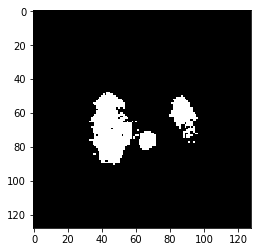

In [41]:
plt.imshow(X_mask[0,0,...]*255)

In [6]:
val_acc_list = [];
acc_list = [];
epochs = 50;
batch_size =1 ;
kf = KFold(n_splits=5)
ep=1;
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]


    img_rows, img_cols = 128, 128

    pooling = 'No'
    num_sequence = 28;
    include_top = False;

    input_shape =  [num_sequence,img_rows, img_cols, 3];
    img_input = layers.Input(shape=input_shape)
    inputs = img_input


    x = vgg16_head(inputs);

    # Create model.
    base_model = models.Model(inputs, x, name='vgg16')

    weights ='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5';

    base_model.load_weights(weights)


    head_model = FCHeadNet.build(base_model, 1, 256)

    model = Model(inputs=base_model.input, outputs=head_model)

    Dont_Want_to_train_all = True;


    if (Dont_Want_to_train_all):

      for layer in base_model.layers:
        layer.trainable = False



    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))


    max_val=-1;
    save_acc=0;
    val_acc=history.history['val_accuracy'];
    acc=history.history['accuracy'];
    for h in range(len(val_acc)):
        if(max_val<=val_acc[h]):
            max_val=val_acc[h];
            save_acc=acc[h];
    print("Epoch "+str(ep))
    ep=ep+1;
    print("max_val :"+str(max_val))
    print("save_acc :"+str(save_acc))
    val_acc_list.append(max_val)
    acc_list.append(save_acc)

(?, 224, 224, 3)
self.input_shape_r
(None, 28, 256)
inputs
(?, 28, 1, 256)
dot product
(?, 28, 1, 256)
tanh
(?, 28, 1, 256)
combUV
(?, 28, 1, 256)
attention_weights
(?, 28, 1, 1)
attention_weights sum
(?, 28, 1, 1)
attention_weights last
(?, 28, 1)
output
(?, 256)


W0428 00:57:56.250262 139842270504768 deprecation_wrapper.py:119] From /home/peppermint/.virtualenvs/cv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 72 samples, validate on 19 samples
Epoch 1/50
72/72 [==============================] - 18s 253ms/step - loss: 0.7844 - accuracy: 0.5972 - val_loss: 0.6899 - val_accuracy: 0.5263
Epoch 2/50
72/72 [==============================] - 15s 205ms/step - loss: 0.6261 - accuracy: 0.6389 - val_loss: 0.7229 - val_accuracy: 0.5263
Epoch 3/50
72/72 [==============================] - 15s 203ms/step - loss: 0.6438 - accuracy: 0.6111 - val_loss: 0.6459 - val_accuracy: 0.6316
Epoch 4/50
72/72 [==============================] - 15s 204ms/step - loss: 0.5708 - accuracy: 0.6806 - val_loss: 0.6051 - val_accuracy: 0.6842
Epoch 5/50
72/72 [==============================] - 15s 204ms/step - loss: 0.5705 - accuracy: 0.7361 - val_loss: 0.5920 - val_accuracy: 0.7368
Epoch 6/50
72/72 [==============================] - 15s 205ms/step - loss: 0.5394 - accuracy: 0.7222 - val_loss: 0.5724 - val_accuracy: 0.7368
Epoch 7/50
72/72 [==============================] - 15s 205ms/step - loss: 0.4759 - accuracy: 0.77

Epoch 5/50
73/73 [==============================] - 15s 201ms/step - loss: 0.5129 - accuracy: 0.7534 - val_loss: 0.6169 - val_accuracy: 0.7222
Epoch 6/50
73/73 [==============================] - 15s 201ms/step - loss: 0.4517 - accuracy: 0.7397 - val_loss: 0.6249 - val_accuracy: 0.7222
Epoch 7/50
73/73 [==============================] - 15s 200ms/step - loss: 0.4058 - accuracy: 0.7945 - val_loss: 0.6482 - val_accuracy: 0.6111
Epoch 8/50
73/73 [==============================] - 15s 200ms/step - loss: 0.4504 - accuracy: 0.7945 - val_loss: 0.6409 - val_accuracy: 0.6667
Epoch 9/50
73/73 [==============================] - 15s 204ms/step - loss: 0.3762 - accuracy: 0.8356 - val_loss: 0.9523 - val_accuracy: 0.4444
Epoch 10/50
73/73 [==============================] - 15s 203ms/step - loss: 0.3138 - accuracy: 0.8493 - val_loss: 0.6738 - val_accuracy: 0.6111
Epoch 11/50
73/73 [==============================] - 15s 203ms/step - loss: 0.2492 - accuracy: 0.9315 - val_loss: 0.5070 - val_accuracy: 0.77

73/73 [==============================] - 17s 226ms/step - loss: 0.2287 - accuracy: 0.9452 - val_loss: 0.4521 - val_accuracy: 0.7222
Epoch 14/50
73/73 [==============================] - 17s 227ms/step - loss: 0.1852 - accuracy: 0.9315 - val_loss: 0.5215 - val_accuracy: 0.7778
Epoch 15/50
73/73 [==============================] - 16s 224ms/step - loss: 0.1422 - accuracy: 0.9589 - val_loss: 0.3250 - val_accuracy: 0.8889
Epoch 16/50
73/73 [==============================] - 16s 226ms/step - loss: 0.0987 - accuracy: 1.0000 - val_loss: 0.7340 - val_accuracy: 0.6667
Epoch 17/50
73/73 [==============================] - 17s 227ms/step - loss: 0.0830 - accuracy: 0.9863 - val_loss: 0.2953 - val_accuracy: 0.8889
Epoch 18/50
73/73 [==============================] - 17s 226ms/step - loss: 0.0481 - accuracy: 1.0000 - val_loss: 0.2880 - val_accuracy: 0.8889
Epoch 19/50
73/73 [==============================] - 16s 226ms/step - loss: 0.0545 - accuracy: 1.0000 - val_loss: 0.3270 - val_accuracy: 0.8889
Epoc

Text(0.5, 0, 'fold')

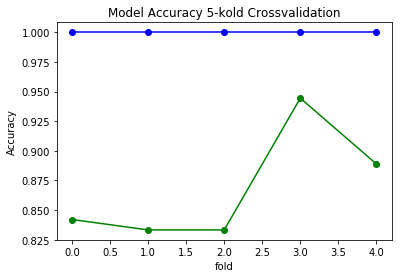

In [12]:
plt.plot(val_acc_list,'go-')
plt.plot(acc_list,'bo-')
plt.title('Model Accuracy 5-kold Crossvalidation')
plt.ylabel('Accuracy')
plt.xlabel('fold')

In [14]:
print("Average Train accuracy "+str(np.mean(acc_list)*100)+'%')

print("Average Validation accuracy "+str(np.mean(val_acc_list)*100)+'%')


Average Train accuracy 100.0%
Average Validation accuracy 86.84210419654846%


In [15]:
acc_list

[1.0, 1.0, 1.0, 1.0, 1.0]

In [16]:
val_acc_list

[0.8421052694320679,
 0.8333333134651184,
 0.8333333134651184,
 0.9444444179534912,
 0.8888888955116272]

In [42]:


val_acc_list = [];
acc_list = [];
epochs = 50;
batch_size =1 ;
kf = KFold(n_splits=5)
ep=1;
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    x_test_mask = (x_test[...,0]>0.2) | (x_test[...,1]>0.2) | (x_test[...,2]>0.2)
    x_test_mask  = x_test_mask*1;
    x_test_mask = x_test_mask[...,None]
    x_test_mask =np.concatenate([x_test_mask,x_test_mask,x_test_mask],axis=-1)

    img_rows, img_cols = 128, 128

    pooling = 'No'
    num_sequence = 28;
    include_top = False;

    input_shape =  [num_sequence,img_rows, img_cols, 3];
    img_input = layers.Input(shape=input_shape)
    inputs = img_input


    x = vgg16_head(inputs);

    # Create model.
    base_model = models.Model(inputs, x, name='vgg16')

    weights ='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5';

    base_model.load_weights(weights)


    head_model = FCHeadNet.build(base_model, 1, 256)

    model = Model(inputs=base_model.input, outputs=head_model)

    Dont_Want_to_train_all = True;


    if (Dont_Want_to_train_all):

      for layer in base_model.layers:
        layer.trainable = False



    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test_mask, y_test))


    max_val=-1;
    save_acc=0;
    val_acc=history.history['val_accuracy'];
    acc=history.history['accuracy'];
    for h in range(len(val_acc)):
        if(max_val<=val_acc[h]):
            max_val=val_acc[h];
            save_acc=acc[h];
    print("Epoch "+str(ep))
    ep=ep+1;
    print("max_val :"+str(max_val))
    print("save_acc :"+str(save_acc))
    val_acc_list.append(max_val)
    acc_list.append(save_acc)

(?, 224, 224, 3)
self.input_shape_r
(None, 28, 256)
inputs
(?, 28, 1, 256)
dot product
(?, 28, 1, 256)
tanh
(?, 28, 1, 256)
combUV
(?, 28, 1, 256)
attention_weights
(?, 28, 1, 1)
attention_weights sum
(?, 28, 1, 1)
attention_weights last
(?, 28, 1)
output
(?, 256)


W0428 14:31:47.470187 140344891041600 deprecation_wrapper.py:119] From /home/peppermint/.virtualenvs/cv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 72 samples, validate on 19 samples
Epoch 1/50
72/72 [==============================] - 23s 315ms/step - loss: 0.7589 - accuracy: 0.6111 - val_loss: 1.2177 - val_accuracy: 0.4211
Epoch 2/50
72/72 [==============================] - 19s 261ms/step - loss: 0.7146 - accuracy: 0.6528 - val_loss: 0.7155 - val_accuracy: 0.4737
Epoch 3/50
72/72 [==============================] - 19s 260ms/step - loss: 0.6279 - accuracy: 0.6667 - val_loss: 0.6268 - val_accuracy: 0.6316
Epoch 4/50
72/72 [==============================] - 18s 248ms/step - loss: 0.5918 - accuracy: 0.6528 - val_loss: 0.7984 - val_accuracy: 0.4737
Epoch 5/50
72/72 [==============================] - 17s 232ms/step - loss: 0.5712 - accuracy: 0.7500 - val_loss: 0.9510 - val_accuracy: 0.4211
Epoch 6/50
72/72 [==============================] - 16s 223ms/step - loss: 0.5003 - accuracy: 0.7917 - val_loss: 1.1114 - val_accuracy: 0.4737
Epoch 7/50
72/72 [==============================] - 16s 221ms/step - loss: 0.4979 - accuracy: 0.77

Epoch 5/50
73/73 [==============================] - 15s 212ms/step - loss: 0.5284 - accuracy: 0.7260 - val_loss: 0.8494 - val_accuracy: 0.6111
Epoch 6/50
73/73 [==============================] - 16s 214ms/step - loss: 0.4987 - accuracy: 0.7397 - val_loss: 0.8904 - val_accuracy: 0.6111
Epoch 7/50
73/73 [==============================] - 16s 220ms/step - loss: 0.4570 - accuracy: 0.7671 - val_loss: 0.6277 - val_accuracy: 0.6667
Epoch 8/50
73/73 [==============================] - 16s 219ms/step - loss: 0.3836 - accuracy: 0.8356 - val_loss: 0.7025 - val_accuracy: 0.6667
Epoch 9/50
73/73 [==============================] - 16s 220ms/step - loss: 0.3399 - accuracy: 0.8082 - val_loss: 0.6298 - val_accuracy: 0.6667
Epoch 10/50
73/73 [==============================] - 16s 219ms/step - loss: 0.3465 - accuracy: 0.8082 - val_loss: 0.9966 - val_accuracy: 0.6111
Epoch 11/50
73/73 [==============================] - 16s 219ms/step - loss: 0.1877 - accuracy: 0.9589 - val_loss: 0.6821 - val_accuracy: 0.77

73/73 [==============================] - 21s 285ms/step - loss: 0.2999 - accuracy: 0.8904 - val_loss: 0.4504 - val_accuracy: 0.7778
Epoch 10/50
73/73 [==============================] - 21s 291ms/step - loss: 0.2644 - accuracy: 0.9041 - val_loss: 0.7437 - val_accuracy: 0.7222
Epoch 11/50
73/73 [==============================] - 21s 281ms/step - loss: 0.2223 - accuracy: 0.9178 - val_loss: 0.5939 - val_accuracy: 0.7222
Epoch 12/50
73/73 [==============================] - 21s 290ms/step - loss: 0.1212 - accuracy: 0.9863 - val_loss: 0.5404 - val_accuracy: 0.7222
Epoch 13/50
73/73 [==============================] - 21s 286ms/step - loss: 0.0851 - accuracy: 1.0000 - val_loss: 0.6476 - val_accuracy: 0.7222
Epoch 14/50
73/73 [==============================] - 19s 263ms/step - loss: 0.0604 - accuracy: 1.0000 - val_loss: 0.6550 - val_accuracy: 0.7222
Epoch 15/50
73/73 [==============================] - 18s 249ms/step - loss: 0.0420 - accuracy: 1.0000 - val_loss: 0.6677 - val_accuracy: 0.7222
Epoc

73/73 [==============================] - 19s 255ms/step - loss: 0.0626 - accuracy: 1.0000 - val_loss: 1.2253 - val_accuracy: 0.5556
Epoch 14/50
73/73 [==============================] - 19s 254ms/step - loss: 0.0377 - accuracy: 1.0000 - val_loss: 1.6572 - val_accuracy: 0.5556
Epoch 15/50
73/73 [==============================] - 19s 254ms/step - loss: 0.0434 - accuracy: 0.9863 - val_loss: 2.1508 - val_accuracy: 0.5556
Epoch 16/50
73/73 [==============================] - 19s 254ms/step - loss: 0.0354 - accuracy: 1.0000 - val_loss: 2.4547 - val_accuracy: 0.5556
Epoch 17/50
73/73 [==============================] - 19s 254ms/step - loss: 0.0411 - accuracy: 0.9863 - val_loss: 2.4886 - val_accuracy: 0.5556
Epoch 18/50
73/73 [==============================] - 19s 254ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 1.6386 - val_accuracy: 0.6111
Epoch 19/50
73/73 [==============================] - 19s 258ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 2.5795 - val_accuracy: 0.5556
Epoc

73/73 [==============================] - 20s 275ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 1.2710 - val_accuracy: 0.7222
Epoch 18/50
73/73 [==============================] - 20s 274ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 1.1703 - val_accuracy: 0.6667
Epoch 19/50
73/73 [==============================] - 20s 277ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 1.2040 - val_accuracy: 0.7222
Epoch 20/50
73/73 [==============================] - 20s 278ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 1.0960 - val_accuracy: 0.7222
Epoch 21/50
73/73 [==============================] - 21s 281ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 1.2315 - val_accuracy: 0.7222
Epoch 22/50
73/73 [==============================] - 20s 276ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.3530 - val_accuracy: 0.7222
Epoch 23/50
73/73 [==============================] - 20s 279ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.2568 - val_accuracy: 0.7222
Epoc

Text(0.5, 0, 'fold')

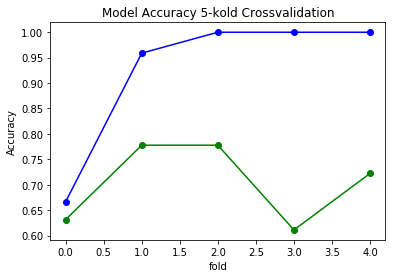

In [43]:
plt.plot(val_acc_list,'go-')
plt.plot(acc_list,'bo-')
plt.title('Model Accuracy 5-kold Crossvalidation')
plt.ylabel('Accuracy')
plt.xlabel('fold')

In [44]:
print("Average Train accuracy "+str(np.mean(acc_list)*100)+'%')

print("Average Validation accuracy "+str(np.mean(val_acc_list)*100)+'%')


Average Train accuracy 92.51141548156738%
Average Validation accuracy 70.40935635566711%


In [ ]:
?, 224, 224, 3)
self.input_shape_r
(None, 28, 256)
inputs
(?, 28, 1, 256)
dot product
(?, 28, 1, 256)
tanh
(?, 28, 1, 256)
combUV
(?, 28, 1, 256)
attention_weights
(?, 28, 1, 1)
attention_weights sum
(?, 28, 1, 1)
attention_weights last
(?, 28, 1)
output
(?, 256)

W0428 14:31:47.470187 140344891041600 deprecation_wrapper.py:119] From /home/peppermint/.virtualenvs/cv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

Train on 72 samples, validate on 19 samples
Epoch 1/50
72/72 [==============================] - 23s 315ms/step - loss: 0.7589 - accuracy: 0.6111 - val_loss: 1.2177 - val_accuracy: 0.4211
Epoch 2/50
72/72 [==============================] - 19s 261ms/step - loss: 0.7146 - accuracy: 0.6528 - val_loss: 0.7155 - val_accuracy: 0.4737
Epoch 3/50
72/72 [==============================] - 19s 260ms/step - loss: 0.6279 - accuracy: 0.6667 - val_loss: 0.6268 - val_accuracy: 0.6316
Epoch 4/50
72/72 [==============================] - 18s 248ms/step - loss: 0.5918 - accuracy: 0.6528 - val_loss: 0.7984 - val_accuracy: 0.4737
Epoch 5/50
72/72 [==============================] - 17s 232ms/step - loss: 0.5712 - accuracy: 0.7500 - val_loss: 0.9510 - val_accuracy: 0.4211
Epoch 6/50
72/72 [==============================] - 16s 223ms/step - loss: 0.5003 - accuracy: 0.7917 - val_loss: 1.1114 - val_accuracy: 0.4737
Epoch 7/50
72/72 [==============================] - 16s 221ms/step - loss: 0.4979 - accuracy: 0.7778 - val_loss: 1.6039 - val_accuracy: 0.4211
Epoch 8/50
72/72 [==============================] - 16s 221ms/step - loss: 0.3725 - accuracy: 0.8333 - val_loss: 1.2961 - val_accuracy: 0.4211
Epoch 9/50
72/72 [==============================] - 16s 221ms/step - loss: 0.3576 - accuracy: 0.8333 - val_loss: 1.0395 - val_accuracy: 0.4737
Epoch 10/50
72/72 [==============================] - 18s 255ms/step - loss: 0.2849 - accuracy: 0.8889 - val_loss: 1.2964 - val_accuracy: 0.4737
Epoch 11/50
72/72 [==============================] - 16s 221ms/step - loss: 0.2018 - accuracy: 0.9306 - val_loss: 1.8770 - val_accuracy: 0.4211
Epoch 12/50
72/72 [==============================] - 16s 221ms/step - loss: 0.1218 - accuracy: 0.9722 - val_loss: 1.4950 - val_accuracy: 0.4737
Epoch 13/50
72/72 [==============================] - 19s 267ms/step - loss: 0.1326 - accuracy: 0.9583 - val_loss: 2.6963 - val_accuracy: 0.4211
Epoch 14/50
72/72 [==============================] - 16s 221ms/step - loss: 0.0753 - accuracy: 0.9861 - val_loss: 2.3202 - val_accuracy: 0.4211
Epoch 15/50
72/72 [==============================] - 15s 211ms/step - loss: 0.0482 - accuracy: 1.0000 - val_loss: 2.4031 - val_accuracy: 0.4737
Epoch 16/50
72/72 [==============================] - 16s 221ms/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 2.2688 - val_accuracy: 0.4737
Epoch 17/50
72/72 [==============================] - 16s 220ms/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 2.6384 - val_accuracy: 0.4737
Epoch 18/50
72/72 [==============================] - 16s 220ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 2.7365 - val_accuracy: 0.4737
Epoch 19/50
72/72 [==============================] - 16s 220ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 3.1013 - val_accuracy: 0.4737
Epoch 20/50
72/72 [==============================] - 17s 237ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 2.5685 - val_accuracy: 0.4737
Epoch 21/50
72/72 [==============================] - 15s 210ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 3.4119 - val_accuracy: 0.4737
Epoch 22/50
72/72 [==============================] - 15s 210ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 3.5135 - val_accuracy: 0.4737
Epoch 23/50
72/72 [==============================] - 15s 209ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 3.3626 - val_accuracy: 0.4737
Epoch 24/50
72/72 [==============================] - 15s 209ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 3.4800 - val_accuracy: 0.4737
Epoch 25/50
72/72 [==============================] - 15s 208ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 3.5597 - val_accuracy: 0.4737
Epoch 26/50
72/72 [==============================] - 15s 209ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 3.4871 - val_accuracy: 0.4737
Epoch 27/50
72/72 [==============================] - 16s 223ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 3.7447 - val_accuracy: 0.4737
Epoch 28/50
72/72 [==============================] - 16s 223ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 3.6538 - val_accuracy: 0.4737
Epoch 29/50
72/72 [==============================] - 16s 223ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 3.6749 - val_accuracy: 0.4737
Epoch 30/50
72/72 [==============================] - 16s 223ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 4.0634 - val_accuracy: 0.4737
Epoch 31/50
72/72 [==============================] - 16s 224ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 3.7831 - val_accuracy: 0.4737
Epoch 32/50
72/72 [==============================] - 16s 223ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 3.8939 - val_accuracy: 0.4737
Epoch 33/50
72/72 [==============================] - 16s 222ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.9635 - val_accuracy: 0.4737
Epoch 34/50
72/72 [==============================] - 16s 222ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.9288 - val_accuracy: 0.4737
Epoch 35/50
72/72 [==============================] - 16s 223ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 4.0188 - val_accuracy: 0.4737
Epoch 36/50
72/72 [==============================] - 16s 223ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 4.0998 - val_accuracy: 0.4737
Epoch 37/50
72/72 [==============================] - 16s 224ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.0762 - val_accuracy: 0.4737
Epoch 38/50
72/72 [==============================] - 16s 222ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.2328 - val_accuracy: 0.4737
Epoch 39/50
72/72 [==============================] - 16s 223ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 4.3179 - val_accuracy: 0.4737
Epoch 40/50
72/72 [==============================] - 16s 223ms/step - loss: 9.8091e-04 - accuracy: 1.0000 - val_loss: 4.2205 - val_accuracy: 0.4737
Epoch 41/50
72/72 [==============================] - 16s 222ms/step - loss: 9.2692e-04 - accuracy: 1.0000 - val_loss: 4.2765 - val_accuracy: 0.4737
Epoch 42/50
72/72 [==============================] - 16s 225ms/step - loss: 8.3063e-04 - accuracy: 1.0000 - val_loss: 4.3987 - val_accuracy: 0.4737
Epoch 43/50
72/72 [==============================] - 16s 223ms/step - loss: 8.3398e-04 - accuracy: 1.0000 - val_loss: 4.3893 - val_accuracy: 0.4737
Epoch 44/50
72/72 [==============================] - 16s 223ms/step - loss: 7.4016e-04 - accuracy: 1.0000 - val_loss: 4.3387 - val_accuracy: 0.4737
Epoch 45/50
72/72 [==============================] - 16s 222ms/step - loss: 6.8092e-04 - accuracy: 1.0000 - val_loss: 4.4394 - val_accuracy: 0.4737
Epoch 46/50
72/72 [==============================] - 16s 222ms/step - loss: 6.3715e-04 - accuracy: 1.0000 - val_loss: 4.5962 - val_accuracy: 0.4737
Epoch 47/50
72/72 [==============================] - 16s 224ms/step - loss: 6.1336e-04 - accuracy: 1.0000 - val_loss: 4.3824 - val_accuracy: 0.4737
Epoch 48/50
72/72 [==============================] - 16s 222ms/step - loss: 5.5849e-04 - accuracy: 1.0000 - val_loss: 4.6540 - val_accuracy: 0.4737
Epoch 49/50
72/72 [==============================] - 16s 227ms/step - loss: 5.4880e-04 - accuracy: 1.0000 - val_loss: 4.5676 - val_accuracy: 0.4737
Epoch 50/50
72/72 [==============================] - 16s 225ms/step - loss: 5.0502e-04 - accuracy: 1.0000 - val_loss: 4.5722 - val_accuracy: 0.4737
Epoch 1
max_val :0.6315789222717285
save_acc :0.6666667

In [48]:
val_acc_list_correct = val_acc_list
acc_list_correct = acc_list;

val_acc_list_correct[0] =  0.4737
acc_list_correct[0]=1.0000


Text(0.5, 0, 'fold')

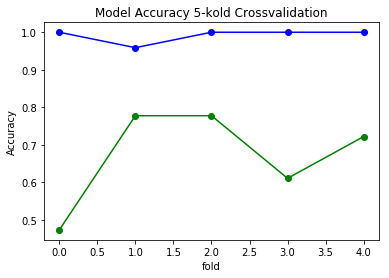

In [49]:
plt.plot(val_acc_list,'go-')
plt.plot(acc_list,'bo-')
plt.title('Model Accuracy 5-kold Crossvalidation')
plt.ylabel('Accuracy')
plt.xlabel('fold')

In [50]:
print("Average Train accuracy "+str(np.mean(acc_list)*100)+'%')

print("Average Validation accuracy "+str(np.mean(val_acc_list)*100)+'%')


Average Train accuracy 99.17808175086975%
Average Validation accuracy 67.25177791023255%


In [52]:
val_acc_list

[0.4737,
 0.7777777910232544,
 0.7777777910232544,
 0.6111111044883728,
 0.7222222089767456]

In [53]:
acc_list

[1.0, 0.9589041, 1.0, 1.0, 1.0]

In [ ]:
epoch 3
- accuracy: 0.6667 - val_loss: 0.6268 - val_accuracy: 0.6316

In [56]:


val_acc_list = [];
acc_list = [];
epochs = 50;
batch_size =1 ;
kf = KFold(n_splits=5)
ep=1;
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    x_train_mask = (x_train[...,0]>0.2) | (x_train[...,1]>0.2) | (x_train[...,2]>0.2)
    x_train_mask  = x_train_mask*1;
    x_train_mask = x_train_mask[...,None]
    x_train_mask =np.concatenate([x_train_mask,x_train_mask,x_train_mask],axis=-1)
    
    
    x_test_mask = (x_test[...,0]>0.2) | (x_test[...,1]>0.2) | (x_test[...,2]>0.2)
    x_test_mask  = x_test_mask*1;
    x_test_mask = x_test_mask[...,None]
    x_test_mask =np.concatenate([x_test_mask,x_test_mask,x_test_mask],axis=-1)

    img_rows, img_cols = 128, 128

    pooling = 'No'
    num_sequence = 28;
    include_top = False;

    input_shape =  [num_sequence,img_rows, img_cols, 3];
    img_input = layers.Input(shape=input_shape)
    inputs = img_input


    x = vgg16_head(inputs);

    # Create model.
    base_model = models.Model(inputs, x, name='vgg16')

    weights ='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5';

    base_model.load_weights(weights)


    head_model = FCHeadNet.build(base_model, 1, 256)

    model = Model(inputs=base_model.input, outputs=head_model)

    Dont_Want_to_train_all = True;


    if (Dont_Want_to_train_all):

      for layer in base_model.layers:
        layer.trainable = False



    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

    history = model.fit(x_train_mask, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test_mask, y_test))


    max_val=-1;
    save_acc=0;
    val_acc=history.history['val_accuracy'];
    acc=history.history['accuracy'];
    for h in range(len(val_acc)):
        if(max_val<=val_acc[h]):
            max_val=val_acc[h];
            save_acc=acc[h];
    print("Epoch "+str(ep))
    ep=ep+1;
    print("max_val :"+str(max_val))
    print("save_acc :"+str(save_acc))
    val_acc_list.append(max_val)
    acc_list.append(save_acc)

(?, 224, 224, 3)
self.input_shape_r
(None, 28, 256)
inputs
(?, 28, 1, 256)
dot product
(?, 28, 1, 256)
tanh
(?, 28, 1, 256)
combUV
(?, 28, 1, 256)
attention_weights
(?, 28, 1, 1)
attention_weights sum
(?, 28, 1, 1)
attention_weights last
(?, 28, 1)
output
(?, 256)
Train on 72 samples, validate on 19 samples
Epoch 1/50


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[28,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node time_distributed_179/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Mean_8/_2813]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[28,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node time_distributed_179/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.